## This File apply EDA to find the most liveable and affordable suburbs.
Created by Wanyu Xu 02-10-2024

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

In [2]:
# define path
base_dir = '../../data/'
raw_dir = os.path.join(base_dir, 'raw')
curated_dir = os.path.join(base_dir, 'curated')

# define the plot output dir
plot_dir = '../../plots'
subfolder = 'liveability_affordability'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

if not os.path.exists(os.path.join(plot_dir, subfolder)):
    os.makedirs(os.path.join(plot_dir, subfolder))

In [3]:
# read data
df_overall = pd.read_csv(f'{curated_dir}/Liveable_Affordable_score_overall.csv')
df_young = pd.read_csv(f'{curated_dir}/Liveable_Affordable_score_young.csv')
df_family = pd.read_csv(f'{curated_dir}/Liveable_Affordable_score_family.csv')
df_old = pd.read_csv(f'{curated_dir}/Liveable_Affordable_score_old.csv')

In [4]:
# Rename columns
df_overall.rename(columns={'Liveable Score': 'liveable_score_overall', 'Final Affordable Score': 'affordable_score_overall', 'live_afford_score': 'live_afford_score_overall'}, inplace=True)
df_young.rename(columns={'Liveable Score': 'liveable_score_young', 'Final Affordable Score': 'affordable_score_young', 'live_afford_score': 'live_afford_score_young'}, inplace=True)
df_family.rename(columns={'Liveable Score': 'liveable_score_family', 'Final Affordable Score': 'affordable_score_family', 'live_afford_score': 'live_afford_score_family'}, inplace=True)
df_old.rename(columns={'Liveable Score': 'liveable_score_old', 'Final Affordable Score': 'affordable_score_old', 'live_afford_score': 'live_afford_score_old'}, inplace=True)


In [5]:
# Merge all live_afford_score, prepare for further analysis
merged_df = df_overall.merge(df_young, on='Suburb', how='outer') \
               .merge(df_family, on='Suburb', how='outer') \
               .merge(df_old, on='Suburb', how='outer')

merged_df.head()

,Suburb,liveable_score_overall,affordable_score_overall,live_afford_score_overall,liveable_score_young,affordable_score_young,live_afford_score_young,liveable_score_family,affordable_score_family,live_afford_score_family,liveable_score_old,affordable_score_old,live_afford_score_old
0,Albert Park-Middle Park-West St Kilda,81.833627,56.628983,71.751769,79.773910,56.628983,70.515940,88.601004,56.628983,75.812196,73.687403,56.628983,66.864035
1,Altona,43.774541,48.426402,45.635286,45.116140,48.426402,46.440245,44.135607,48.426402,45.851925,41.117061,48.426402,44.040798
2,Armadale,75.418963,53.116746,66.498076,65.733586,53.116746,60.686850,60.545970,53.116746,57.574280,46.357254,53.116746,49.061051
3,Aspendale-Chelsea-Carrum,39.192812,50.707898,43.798846,42.888154,50.707898,46.016051,48.088996,50.707898,49.136556,35.943276,50.707898,41.849125
4,Bairnsdale,16.799699,55.197117,32.158666,16.636717,55.197117,32.060877,24.269611,55.197117,36.640613,36.390484,55.197117,43.913137


# EDA

# Top 10
- Draw heatmap to analyze top 10 suburbs with the highest live_afford_score

##### Top 10 suburb based on overall live_afford_score

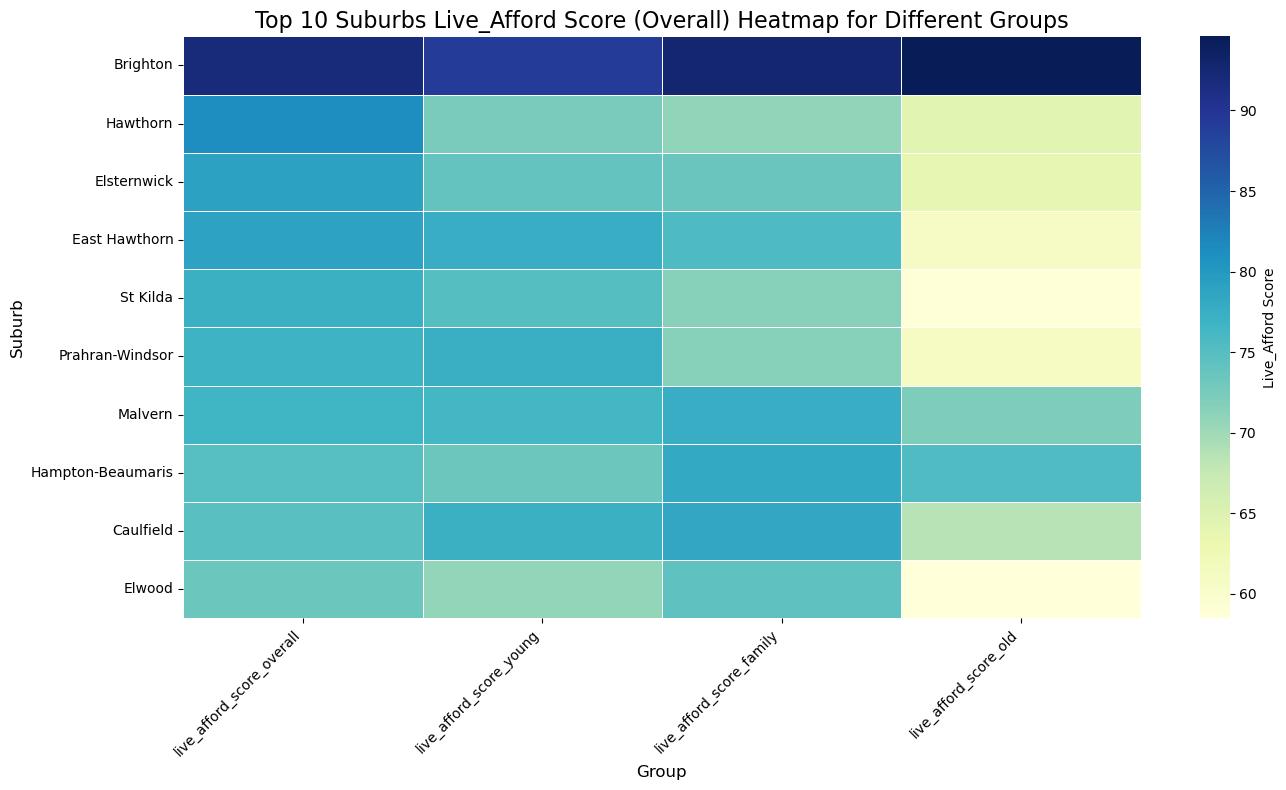

In [6]:
# Select Top 10 suburb based on overall live_afford_score
top_10_df = merged_df[['Suburb', 'live_afford_score_overall', 'live_afford_score_young', 
                       'live_afford_score_family', 'live_afford_score_old']].sort_values(
                           by='live_afford_score_overall', ascending=False).head(10)

# Set 'Suburb' as the index for better plotting
top_10_df_indexed = top_10_df.set_index('Suburb')

# Increase figure size for better readability
plt.figure(figsize=(14, 8))

# Create the heatmap without annotations
sns.heatmap(
    top_10_df_indexed,
    cmap="YlGnBu",
    linewidths=0.5,  # Add lines between cells
    cbar_kws={"label": "Live_Afford Score"},  # Label for the color bar
    xticklabels=True,  # Show x-axis labels
    yticklabels=True  # Show y-axis labels
)

# Improve label readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)  # Ensure y-axis labels stay horizontal

# Add titles and labels
plt.title('Top 10 Suburbs Live_Afford Score (Overall) Heatmap for Different Groups', fontsize=16)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Suburb', fontsize=12)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Save the figure
plt.savefig(f'{plot_dir}/{subfolder}/top_10_live_afford_score_overall', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


##### Top 10 suburb base on all four live_afford_score

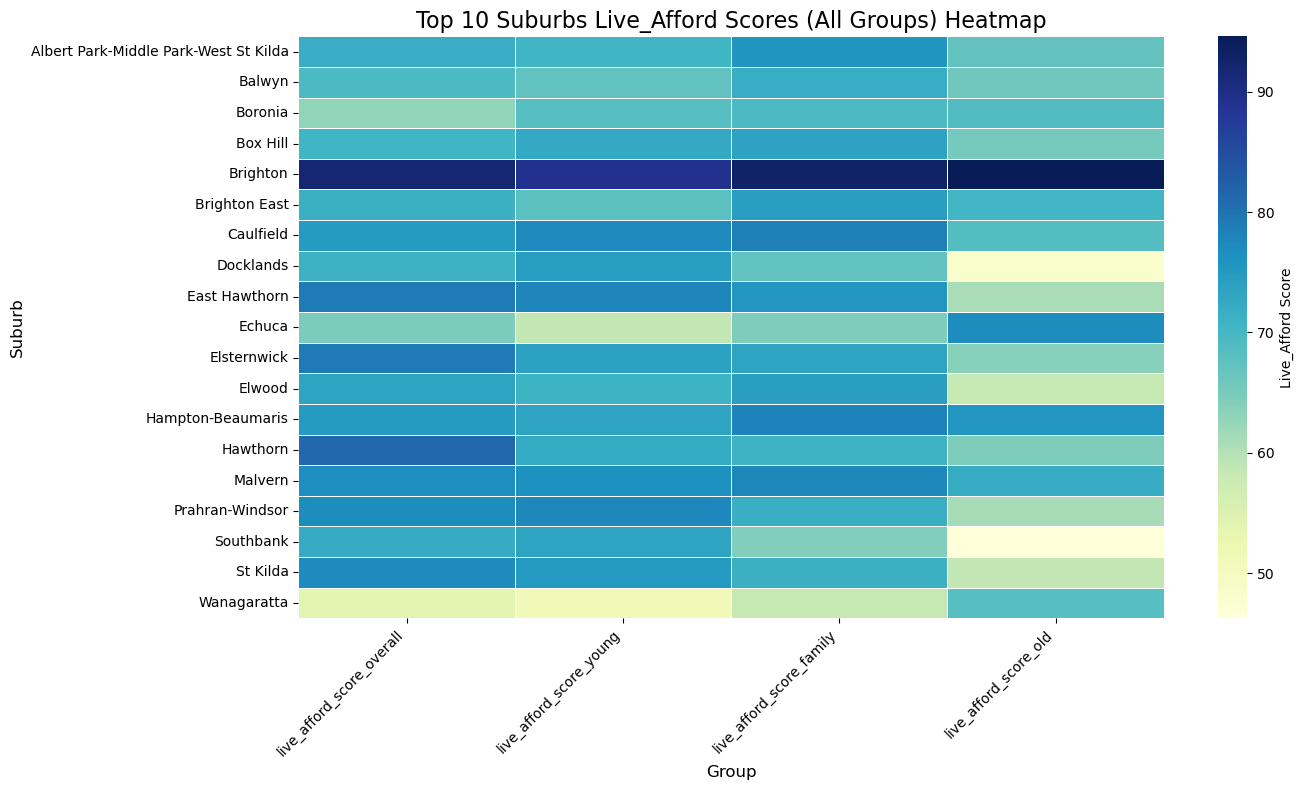

In [7]:
# Define the score columns
score_columns = ['live_afford_score_overall', 'live_afford_score_young', 
                 'live_afford_score_family', 'live_afford_score_old']

# Get top 10 for each column and concatenate them, dropping duplicates based on 'Suburb'
top_10_dfs = [merged_df[['Suburb', col]].sort_values(by=col, ascending=False).head(10) for col in score_columns]
combined_top_10 = pd.concat(top_10_dfs).drop_duplicates(subset='Suburb')

# Merge the resulting dataframe to get the relevant live_afford_score columns for the selected suburbs
final_top_10_df = merged_df[merged_df['Suburb'].isin(combined_top_10['Suburb'])][['Suburb'] + score_columns]

# Set 'Suburb' as the index for better plotting
final_top_10_df.set_index('Suburb', inplace=True)

# Increase figure size for better readability
plt.figure(figsize=(14, 8))

# Create the heatmap without annotations
sns.heatmap(
    final_top_10_df,
    cmap="YlGnBu",
    linewidths=0.5,  # Add lines between cells
    cbar_kws={"label": "Live_Afford Score"}  # Label for the color bar
)

# Improve label readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)  # Ensure y-axis labels stay horizontal

# Add titles and labels
plt.title('Top 10 Suburbs Live_Afford Scores (All Groups) Heatmap', fontsize=16)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Suburb', fontsize=12)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

plt.savefig(f'{plot_dir}/{subfolder}/top_10_live_afford_score_All_groups', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


Through these two heatmaps, we identified the best-performing suburbs and analyzed the differences in how these top 10 suburbs perform among different groups (young people, families, and seniors). Some suburbs show particularly excellent overall performance for the elderly, while others are more suitable for young people. Certain suburbs stand out in terms of overall livability and affordability, but may display distinct advantages and disadvantages across different groups. Based on these analyses, we can provide more tailored living recommendations for various groups, helping them find the best balance between livability and affordability.

# The trade-off between livability and affordability in suburb

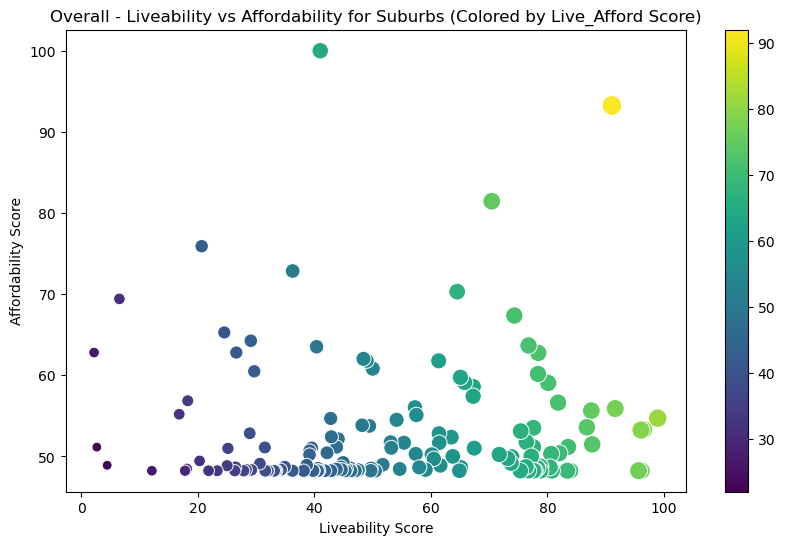

In [8]:
# Plot a scatter plot showing the relationship between liveability and affordability, with color based on live_afford_score_overall
plt.figure(figsize=(10, 6))

# Create scatterplot and return the mappable object
scatter = sns.scatterplot(
    x='liveable_score_overall',
    y='affordable_score_overall',
    data=df_overall,
    hue='live_afford_score_overall',
    palette='viridis',  # Gradient color palette
    size='live_afford_score_overall',  # Optional: adjust point size based on live_afford_score
    sizes=(50, 200),  # Range of point sizes
    legend=False  # Remove legend
)

plt.title('Overall - Liveability vs Affordability for Suburbs (Colored by Live_Afford Score)')
plt.xlabel('Liveability Score')
plt.ylabel('Affordability Score')

# Create a normalization object for the colorbar
norm = plt.Normalize(vmin=merged_df['live_afford_score_overall'].min(), vmax=merged_df['live_afford_score_overall'].max())

# Add a colorbar and ensure it is linked to the scatterplot
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Add colorbar
plt.colorbar(sm, ax=scatter.axes)

plt.savefig(f'{plot_dir}/{subfolder}/live_vs_afford_overall_suburb_scatter', dpi=300, bbox_inches='tight')

# Display the chart
plt.show()


This scatter plot reveals the trade-off between liveability and affordability in suburbs. Many suburbs face a certain contradiction between the two: areas with high liveability often come with higher living costs. A few suburbs, however, have achieved a good balance between liveability and affordability, showing high overall scores, making them potentially the most attractive places to live.

Most suburbs have their strengths in either liveability or affordability. Some are better suited for those seeking a higher quality of life, while others are more suitable for budget-conscious residents. For suburbs with lower overall scores, it may be necessary to explore ways to improve both the quality of life and convenience while keeping living costs under control, to attract more residents.

# K-Means
- Classify suburbs based on the live_afford_score of different groups to reveal regions with similar liva_afford patterns

In [9]:
# Select columns for clustering
cluster_data = merged_df[score_columns]

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(cluster_data)
merged_df['cluster'] = kmeans.labels_

# Group by cluster and display the results
mdf_cluster = merged_df.groupby('cluster')[score_columns].mean()
mdf_cluster


,live_afford_score_overall,live_afford_score_young,live_afford_score_family,live_afford_score_old
cluster,,,,
0,54.700778,54.454295,56.512957,50.447018
1,38.744297,38.582133,41.579188,40.779495
2,70.405783,69.109825,69.433594,61.359686


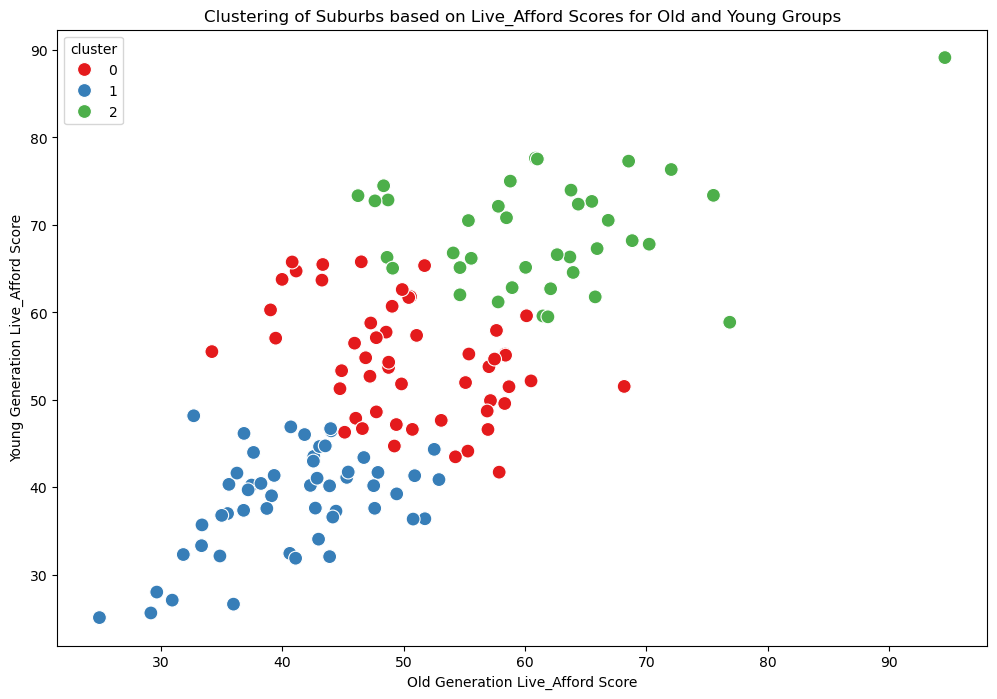

In [10]:
# Plot the liveability index for each group, with color differentiation based on clustering results
plt.figure(figsize=(12, 8))
sns.scatterplot(x='live_afford_score_old', y='live_afford_score_young', hue='cluster', data=merged_df, palette='Set1', s=100)
plt.title('Clustering of Suburbs based on Live_Afford Scores for Old and Young Groups')
plt.xlabel('Old Generation Live_Afford Score')
plt.ylabel('Young Generation Live_Afford Score')

plt.savefig(f'{plot_dir}/{subfolder}/live_afford_score_cluster_old_young', dpi=300, bbox_inches='tight')

plt.show()


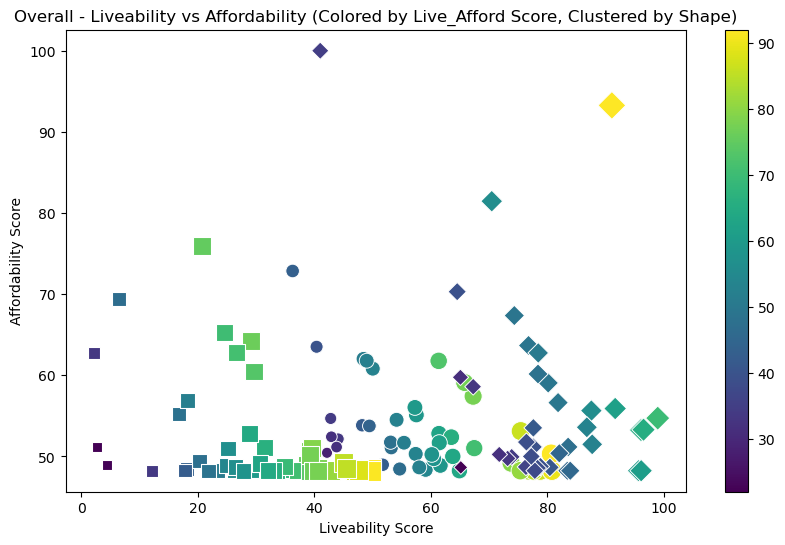

In [11]:
# Create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# Define different markers for each cluster
markers = {0: 'o', 1: 's', 2: 'D'}  # Cluster 0: Circle, Cluster 1: Square, Cluster 2: Diamond

# Loop through and plot points for each cluster
for cluster_val, marker in markers.items():
    sns.scatterplot(
        x='liveable_score_overall',
        y='affordable_score_overall',
        data=merged_df[merged_df['cluster'] == cluster_val],
        hue='live_afford_score_overall',
        palette='viridis',  # Gradient color palette
        size='live_afford_score_overall',  # Adjust point size based on live_afford_score
        sizes=(50, 200),  # Range of point sizes
        legend=False,  # Remove legend
        marker=marker,
        ax=ax  # Use the same axis object
    )

# Set title and axis labels
plt.title('Overall - Liveability vs Affordability (Colored by Live_Afford Score, Clustered by Shape)')
plt.xlabel('Liveability Score')
plt.ylabel('Affordability Score')

# Create a normalization object for the colorbar
norm = plt.Normalize(vmin=merged_df['live_afford_score_overall'].min(), vmax=merged_df['live_afford_score_overall'].max())

# Add a colorbar and ensure it is linked to the scatterplot
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Add the colorbar
plt.colorbar(sm, ax=ax)

plt.savefig(f'{plot_dir}/{subfolder}/live_vs_afford_overall_suburb_cluster_scatter', dpi=300, bbox_inches='tight')

# Display the chart
plt.show()


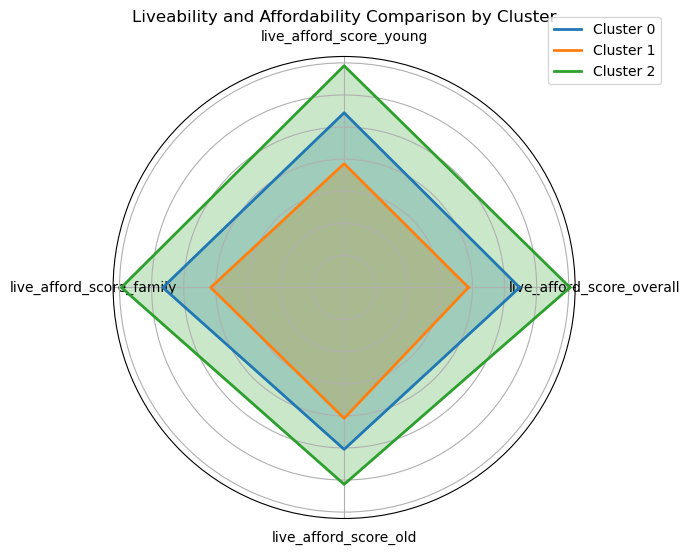

In [12]:
# Get the mean data for each cluster
cluster_means = mdf_cluster.values  # Extract values from the cluster means dataframe
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']  # You can name clusters based on their number

# Set labels for the radar chart (i.e., column names)
labels = score_columns

# Assign an angle to each label in the radar chart
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Close the radar chart

# Create radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot the radar chart for each cluster
for i, cluster_data in enumerate(cluster_means):
    # Add starting point for each cluster to close the radar chart
    values = cluster_data.tolist()
    values += values[:1]
    
    # Plot radar chart lines
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=cluster_names[i])
    
    # Fill radar chart area
    ax.fill(angles, values, alpha=0.25)

# Set chart labels
ax.set_yticklabels([])  # Hide the radial axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Add chart title and legend
plt.title('Liveability and Affordability Comparison by Cluster')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.savefig(f'{plot_dir}/{subfolder}/live_afford_score_cluster_radar', dpi=300, bbox_inches='tight')

# Display chart
plt.show()


In [13]:
merged_df.head()

,Suburb,liveable_score_overall,affordable_score_overall,live_afford_score_overall,liveable_score_young,affordable_score_young,live_afford_score_young,liveable_score_family,affordable_score_family,live_afford_score_family,liveable_score_old,affordable_score_old,live_afford_score_old,cluster
0,Albert Park-Middle Park-West St Kilda,81.833627,56.628983,71.751769,79.773910,56.628983,70.515940,88.601004,56.628983,75.812196,73.687403,56.628983,66.864035,2
1,Altona,43.774541,48.426402,45.635286,45.116140,48.426402,46.440245,44.135607,48.426402,45.851925,41.117061,48.426402,44.040798,1
2,Armadale,75.418963,53.116746,66.498076,65.733586,53.116746,60.686850,60.545970,53.116746,57.574280,46.357254,53.116746,49.061051,0
3,Aspendale-Chelsea-Carrum,39.192812,50.707898,43.798846,42.888154,50.707898,46.016051,48.088996,50.707898,49.136556,35.943276,50.707898,41.849125,1
4,Bairnsdale,16.799699,55.197117,32.158666,16.636717,55.197117,32.060877,24.269611,55.197117,36.640613,36.390484,55.197117,43.913137,1


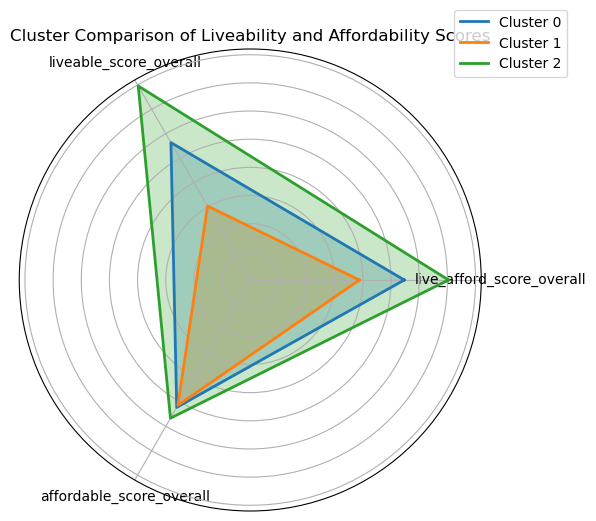

In [14]:
# Select the dimensions you need to plot for the radar chart
overall_columns = ['live_afford_score_overall', 'liveable_score_overall', 'affordable_score_overall']

# Get the mean data for each cluster
cluster_means = merged_df.groupby('cluster')[overall_columns].mean().values  # Extract cluster means
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']  # You can name clusters based on actual cluster count

# Set the radar chart labels to the selected column names
labels = overall_columns

# Assign angles to each label for the radar chart
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Close the radar chart

# Create radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot the radar chart for each cluster
for i, cluster_data in enumerate(cluster_means):
    # Add the starting point to close the radar chart for each cluster
    values = cluster_data.tolist()
    values += values[:1]
    
    # Plot radar chart lines
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=cluster_names[i])
    
    # Fill the radar chart area
    ax.fill(angles, values, alpha=0.25)

# Set radar chart labels
ax.set_yticklabels([])  # Hide the radial axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Add chart title and legend
plt.title('Cluster Comparison of Liveability and Affordability Scores')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.savefig(f'{plot_dir}/{subfolder}/live_vs_afford_score_cluster_radar', dpi=300, bbox_inches='tight')

# Display the radar chart
plt.show()


In [15]:
# save clustering result
merged_df.to_csv((f'{curated_dir}/Liveable_Affordable_Score_All_with_cluster.csv'))
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Suburb                     143 non-null    object 
 1   liveable_score_overall     143 non-null    float64
 2   affordable_score_overall   143 non-null    float64
 3   live_afford_score_overall  143 non-null    float64
 4   liveable_score_young       143 non-null    float64
 5   affordable_score_young     143 non-null    float64
 6   live_afford_score_young    143 non-null    float64
 7   liveable_score_family      143 non-null    float64
 8   affordable_score_family    143 non-null    float64
 9   live_afford_score_family   143 non-null    float64
 10  liveable_score_old         143 non-null    float64
 11  affordable_score_old       143 non-null    float64
 12  live_afford_score_old      143 non-null    float64
 13  cluster                    143 non-null    int32  

Cluster 2 is the best-performing cluster, offering high livability and economic affordability. It is particularly suitable for young people and families with diverse needs, providing comprehensive convenience and cost-effectiveness. Cluster 0, while overall average, excels in family-friendly living, making it a good choice for those prioritizing family life quality. Cluster 1 performs relatively poorly, especially for the elderly and young people. This may be due to higher economic burdens or a lack of essential facilities and services in the area.